In [73]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import ascii
from astropy.table import Table

BANDS = ['g', 'r', 'i']
UPPER_LIMIT_MAGS = {
    'pstarr' : {'g': 23.3, 'r': 23.2, 'i': 23.1},
    'ztf': {'g': 23.3, 'r': 23.2, 'i': 23.1}
}

In [18]:
from typing import Optional

def img_ab_mag_to_flux(mag: np.ndarray, zero_point: np.ndarray, magerr: Optional[np.ndarray] = None) -> np.ndarray:
    """Inverse of img_flux_to_ab_mag."""
    flux = 10 ** ((mag - zero_point) / -2.5)
    if magerr is not None:
        fluxerr = (magerr * (np.log(10) * flux)) / 2.5
        return flux, fluxerr
    return flux

def get_snr_from_mag(mag, magerr, zp):
        flux, fluxerr = img_ab_mag_to_flux(mag, zero_point=zp, magerr=magerr)
        return flux / fluxerr

In [126]:
data = {'a': [1,2,3], 'b': [4,5,6]}
tab = Table(data)
len(tab)

3

In [123]:
test = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000513_g.ecsv')
pd.value_counts(test['ZTF_gPSFFlags'])
test2 = psf_fit_filter(test, 'g')

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/3377793905.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(test['ZTF_gPSFFlags'])


In [124]:
len(test2) / len(test)

0.316560338348958

In [128]:
def catalog_filter(tab: Table, band: str, copy: bool = True) -> Table:
    # 0 — Both catalogs
    # 1 — ZTF, not Pan-STARRS, and not nan in either
    # 2 — Pan-STARRS, not ZTF, and not nan in either
    # 3 — Nan in either Pan-STARRS or ZTF
    if copy: tab = tab.copy()
    mask = np.isin(tab[f'Catalog_Flag'], [0, 1, 2])
    return tab[mask]

def psf_fit_filter(tab: Table, band: str, copy: bool = True) -> Table:
    # Flags here https://photutils.readthedocs.io/en/stable/api/photutils.psf.PSFPhotometry.html#photutils.psf.PSFPhotometry.__call__
    if copy: tab = tab.copy()
    okay_flags = [0, 4]
    mask = np.isin(tab[f'ZTF_{band}PSFFlags'], okay_flags) | tab['Catalog_Flag'] == 2
    return tab[mask]

def sep_extraction_filter(tab: Table, band: str, copy: bool = True) -> Table:
    # flags here: https://sextractor.readthedocs.io/en/latest/Flagging.html
    if copy: tab = tab.copy()
    okay_flags = [0, 1, 2, 3]
    mask = np.isin(tab[f'ZTF_sepExtractionFlag'], okay_flags) | tab['Catalog_Flag'] == 2
    return tab[mask]

def mag_diff_filter(tab: Table, band: str, copy: bool = True) -> Table:
    if copy: tab = tab.copy()
    pstarr_mag_diff = tab[f'PSTARR_{band}PSFMag'] - tab[f'PSTARR_{band}KronMag']
    ztf_mag_diff = tab[f'ZTF_{band}PSFMag'] - tab[f'ZTF_{band}KronMag']
    mask = (pstarr_mag_diff < 0.05) | (ztf_mag_diff < 0.05)
    return tab[mask]

def snr_filter(tab: Table, band: str, snr_min: float = 3, copy: bool = True) -> Table:
    if copy: tab = tab.copy()
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=25)
    mask = (pstarr_snr > snr_min) | (ztf_snr > snr_min)
    return tab[mask]

def total_filter(original_tab: Table, band: str) -> Table:
    tab = original_tab.copy()
    for filt in [catalog_filter, psf_fit_filter, sep_extraction_filter, mag_diff_filter, snr_filter]:
        tab = filt(tab, band=band, copy=False)
        print(f'{filt.__name__} filtered out {len(original_tab) - len(tab)} / {len(original_tab)} = {(len(original_tab) - len(tab)) / len(original_tab):.2f} sources from {band} band.')
    return tab

# Look at one field (000513)

In [129]:
g_tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000513_g.ecsv')
r_tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000513_r.ecsv')
i_tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000513_i.ecsv')
tables = {'g': g_tab, 'r': r_tab, 'i': i_tab}
tables = {band: total_filter(tab, band=band) for band, tab in tables.items()}
print(len(g_tab), len(r_tab), len(i_tab))
g_tab

catalog_filter filtered out 0 / 364594 = 0.00 sources from g band.
psf_fit_filter filtered out 115810 / 364594 = 0.32 sources from g band.
sep_extraction_filter filtered out 115810 / 364594 = 0.32 sources from g band.
mag_diff_filter filtered out 254502 / 364594 = 0.70 sources from g band.


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


snr_filter filtered out 334915 / 364594 = 0.92 sources from g band.
catalog_filter filtered out 0 / 367393 = 0.00 sources from r band.
psf_fit_filter filtered out 157827 / 367393 = 0.43 sources from r band.
sep_extraction_filter filtered out 157827 / 367393 = 0.43 sources from r band.
mag_diff_filter filtered out 270641 / 367393 = 0.74 sources from r band.
snr_filter filtered out 332158 / 367393 = 0.90 sources from r band.
catalog_filter filtered out 0 / 370099 = 0.00 sources from i band.
psf_fit_filter filtered out 178371 / 370099 = 0.48 sources from i band.
sep_extraction_filter filtered out 178371 / 370099 = 0.48 sources from i band.
mag_diff_filter filtered out 277851 / 370099 = 0.75 sources from i band.
snr_filter filtered out 300823 / 370099 = 0.81 sources from i band.
364594 367393 370099


ra,dec,ZTF_thresh,ZTF_npix,ZTF_tnpix,ZTF_xmin,ZTF_xmax,ZTF_ymin,ZTF_ymax,ZTF_x,ZTF_y,ZTF_x2,ZTF_y2,ZTF_xy,ZTF_errx2,ZTF_erry2,ZTF_errxy,ZTF_a,ZTF_b,ZTF_theta,ZTF_cxx,ZTF_cyy,ZTF_cxy,ZTF_cflux,ZTF_flux,ZTF_cpeak,ZTF_peak,ZTF_xcpeak,ZTF_ycpeak,ZTF_xpeak,ZTF_ypeak,ZTF_sepExtractionFlag,ZTF_gKronMag,ZTF_gKronMagErr,ZTF_gKronCircleFlag,ZTF_gPSFMag,ZTF_gPSFMagErr,ZTF_gPSFFlags,ZTF_g_zero_pt_mag,ZTF_ra,ZTF_dec,PSTARR_PanSTARR_ID,PSTARR_gKronMag,PSTARR_rKronMag,PSTARR_iKronMag,PSTARR_gKronMagErr,PSTARR_rKronMagErr,PSTARR_iKronMagErr,PSTARR_gApMag,PSTARR_rApMag,PSTARR_iApMag,PSTARR_gApMagErr,PSTARR_rApMagErr,PSTARR_iApMagErr,PSTARR_gPSFMag,PSTARR_rPSFMag,PSTARR_iPSFMag,PSTARR_gPSFMagErr,PSTARR_rPSFMagErr,PSTARR_iPSFMagErr,PSTARR_primaryDetection,PSTARR_ra,PSTARR_dec,association_separation_arcsec,Catalog,Catalog_Flag,x,y
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,int64,float64,float64
97.08175275011205,13.558841024064002,0.9287290573120117,7.0,2.0,1065.0,1067.0,70.0,72.0,1066.3556047543802,71.0,0.39882014701680024,0.4575824665064092,0.0,0.021989655853524134,0.025400814595003693,0.0,0.676448404788971,0.6315220594406128,1.5707963705062866,2.5073959827423096,2.1853983402252197,-0.0,11.670082092285156,14.240066528320312,2.770040512084961,7.920257568359375,1066.0,71.0,1066.0,71.0,0.0,20.477273016866356,0.04268176268535784,0.0,21.55990404055993,nan,8.0,26.325,97.0817481600423,13.558720000465804,1.2427097081757125e+17,21.7108001708984,20.0816993713379,18.9260005950928,0.0742729976773262,0.0174209997057915,0.0113340001553297,21.7171001434326,20.0067005157471,18.82080078125,0.00771200004965067,0.00310100009664893,0.00224600010551512,21.3598003387451,19.878999710083,19.1287002563477,0.0427640005946159,0.0105050001293421,0.00946800038218498,1.0,97.0817573401818,13.5589620476622,0.8719619754232865,Both,0,1066.3556047543802,71.0
97.04874471319218,13.558118576438414,0.9287290573120117,15.0,4.0,948.0,952.0,70.0,74.0,950.6340909903331,71.44722348113501,0.8986186341760369,1.0175692657058346,-0.3890000123046571,0.005311659291051615,0.005765293414130344,-0.0021865783947944695,1.1625895500183105,0.7513810992240906,-0.8612571358680725,1.3334927558898926,1.1776117086410522,1.0195447206497192,57.73281478881836,61.999908447265625,10.456466674804688,41.82586669921875,951.0,71.0,951.0,71.0,0.0,18.297689136522685,0.008338856714872842,0.0,19.75378871412548,0.011596367464459018,0.0,26.325,97.04868801609705,13.55814414664663,1.2427097048803019e+17,20.0988998413086,19.3512992858887,18.7915000915527,0.0184969995170832,0.010584999807179,0.0079950001090765,19.9953994750977,19.2605991363525,18.6604995727539,0.00349000003188849,0.00219899998046458,0.0020860000513494,20.0611000061035,19.2215995788574,18.7252006530762,0.0145319998264313,0.00755099998787045,0.00615700008347631,1.0,97.0488014102873,13.5580930062302,0.4374691675146763,Both,0,950.6340909903331,71.44722348113501
97.39975779036062,13.562553476534635,0.9287290573120117,21.0,5.0,2175.0,2181.0,71.0,74.0,2179.066318313008,72.02711902923815,2.1264690871932714,0.5237970532278036,-0.09390947775713343,0.0051934148032282785,0.0008137801374573261,-0.0005563142700010244,1.4601209163665771,0.719939649105072,-0.0583295114338398,0.4740162193775177,1.924372911453247,0.16996894776821136,134.20654296875,135.0598602294922,22.02972984313965,63.691192626953125,2180.0,72.0,2180.0,72.0,0.0,18.154835338245427,0.007892609028928585,0.0,19.33406507397827,0.007868474948226616,0.0,26.325,97.39966435697815,13.562555575587869,1.2427097399866555e+17,19.8419990539551,18.997999191

In [98]:
for k in g_tab.colnames:
    if 'flag' in k.lower():
        print(k)

ZTF_sepExtractionFlag
ZTF_gKronCircleFlag
ZTF_gPSFFlags
Catalog_Flag


In [99]:
# Set values <=0 to the upper limit for ZTF
for band in BANDS:
    tab = tables[band]
    upper_lim_mask = tab[f'ZTF_{band}PSFFlags'] == 4
    tab[f'ZTF_{band}PSFMag'][upper_lim_mask] = UPPER_LIMIT_MAGS['ztf'][band]   # 4 means flux was negative
    tab[f'ZTF_{band}_upper_lim'] = False
    tab[f'ZTF_{band}_upper_lim'][upper_lim_mask] = True
    tables[band] = tab

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


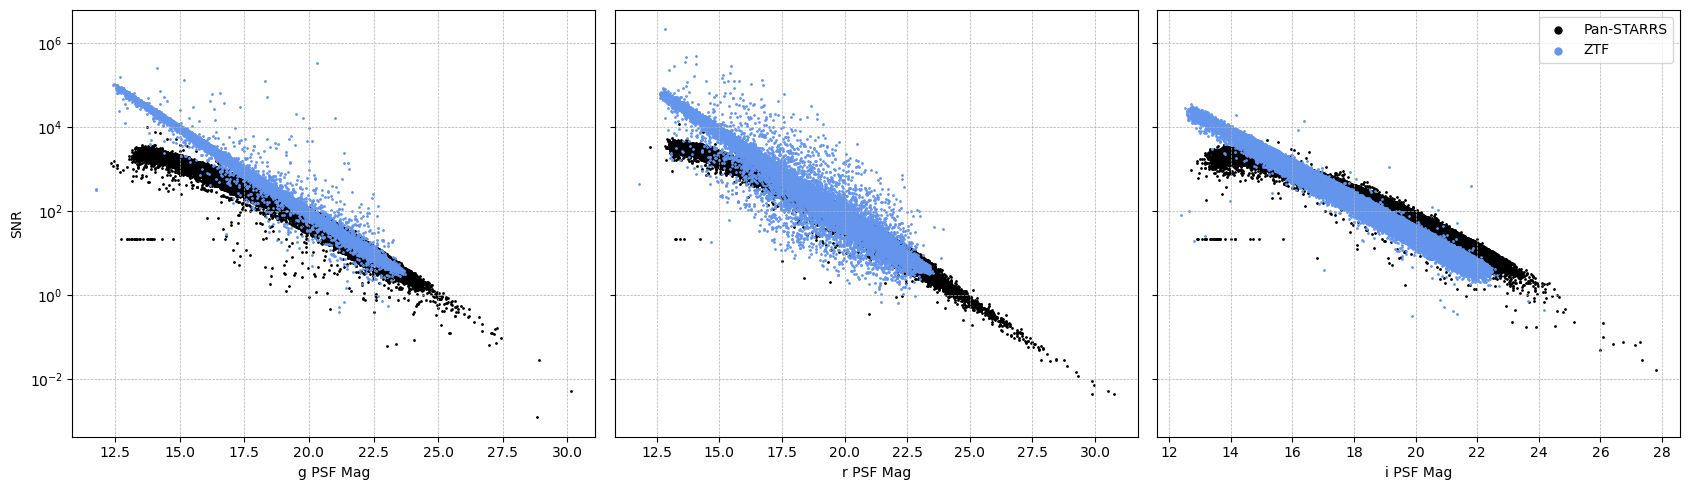

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    # Plot
    ax.scatter(tab[f'PSTARR_{band}PSFMag'], pstarr_snr, color='k', label='Pan-STARRS', s=1)
    ax.scatter(tab[f'ZTF_{band}PSFMag'], ztf_snr, color='cornflowerblue', label='ZTF', s=1)

    # Formatting
    ax.set_yscale('log')
    ax.grid(lw=0.5, ls='--')
    ax.set_xlabel(f'{band} PSF Mag')

axes[0].set_ylabel(f'SNR')
axes[-1].legend(markerscale=5)
plt.tight_layout()
plt.show()

In [101]:
import pandas as pd
for band in BANDS:
    tab = tables[band]
    print(pd.value_counts(tab[f'ZTF_{band}PSFFlags'], normalize=True))

ZTF_gPSFFlags
0.0    0.99999
4.0    0.00001
Name: proportion, dtype: float64
ZTF_rPSFFlags
0.0    0.999985
4.0    0.000015
Name: proportion, dtype: float64
ZTF_iPSFFlags
0.0    1.0
Name: proportion, dtype: float64


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/791066981.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(tab[f'ZTF_{band}PSFFlags'], normalize=True))


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/690818466.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


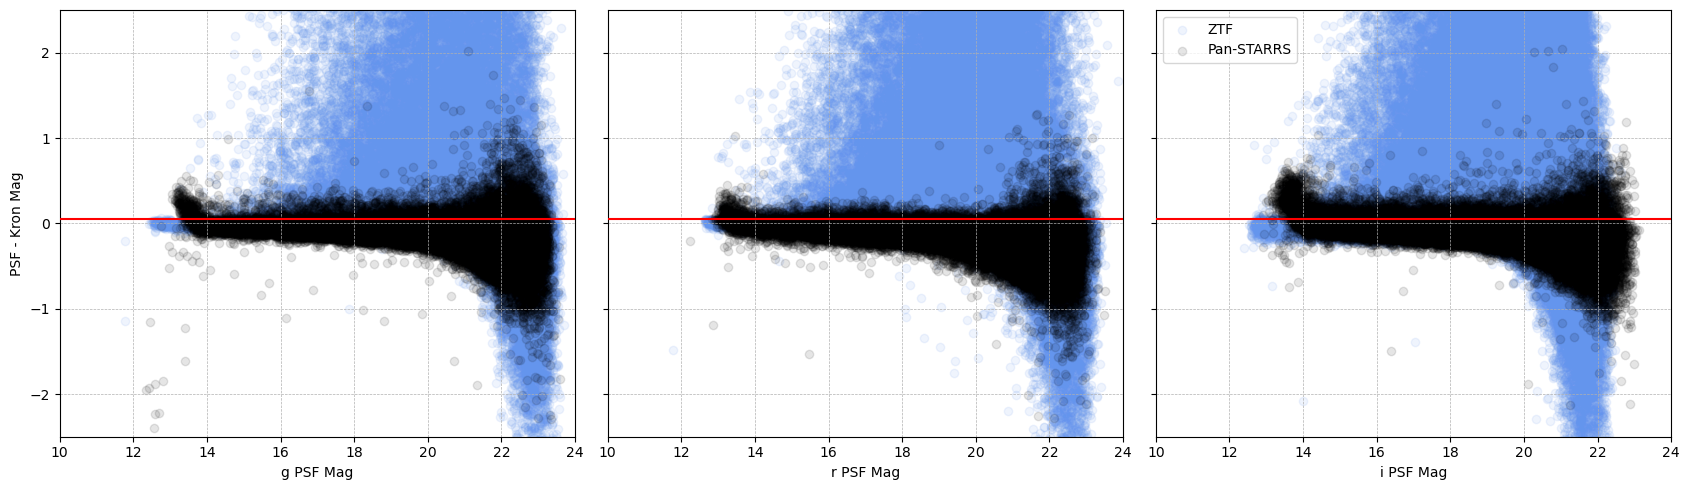

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    ##### BOTH #####
    # Masks
    pstarr_mask = pstarr_snr > 2
    ztf_mask = ztf_snr > 2

    # Plot
    # Without upper lims
    ax.scatter(
        tab[ztf_mask][f'ZTF_{band}PSFMag'],
        tab[ztf_mask][f'ZTF_{band}PSFMag'] - tab[ztf_mask][f'ZTF_{band}KronMag'],
        color='cornflowerblue',
        label='ZTF',
        alpha=0.1
    )
    ax.scatter(
        tab[pstarr_mask][f'PSTARR_{band}PSFMag'],
        tab[pstarr_mask][f'PSTARR_{band}PSFMag'] - tab[pstarr_mask][f'PSTARR_{band}KronMag'],
        color='k',
        label='Pan-STARRS',
        alpha=0.1
    )

    # Formatting
    ax.axhline(0.05, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_xlabel(f'{band} PSF Mag')
    ax.set_ylim((-2.5, 2.5))
    ax.set_xlim((10, 24))

axes[0].set_ylabel(f'PSF - Kron Mag')
axes[-1].legend(markerscale=1)
plt.tight_layout()
plt.show()

In [61]:
from Extracting.Catalogs import PSTARR_Catalog

In [71]:
test = PSTARR_Catalog([88.831, 89.745], [12.668, 13.556])

In [58]:
tab = tables['g'].copy()
pstarr_snr = get_snr_from_mag(tab[f'PSTARR_gPSFMag'], tab[f'PSTARR_gPSFMagErr'], zp=25)
ztf_snr = get_snr_from_mag(tab[f'ZTF_gPSFMag'], tab[f'ZTF_gPSFMagErr'], zp=25)
mask = (pstarr_snr > 6) | (ztf_snr > 6)
tab = tab[mask]

with open('/Users/adamboesky/Desktop/ZTF_unassociated.txt', 'w') as f:
    for x, y in zip(tab[(tab['Catalog_Flag'] == 1)]['x'], tab[(tab['Catalog_Flag'] == 1)]['y']):
        f.write(f"{x} {y}\n")

with open('/Users/adamboesky/Desktop/PSTARR_unassociated.txt', 'w') as f:
    for x, y in zip(tab[(tab['Catalog_Flag'] == 2)]['x'], tab[(tab['Catalog_Flag'] == 2)]['y']):
        f.write(f"{x} {y}\n")

with open('/Users/adamboesky/Desktop/associated.txt', 'w') as f:
    for x, y in zip(tab[(tab['Catalog_Flag'] == 0)]['x'], tab[(tab['Catalog_Flag'] == 0)]['y']):
        f.write(f"{x} {y}\n")

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


In [39]:
from Extracting.Catalogs import ZTF_Catalog

test = ZTF_Catalog(tables['g']['ra'][0], tables['g']['dec'][0], data_dir='/Users/adamboesky/Research/long_transients/Data/ztf_data')
test.sextractors['g'].fits_fpath

Querying metadata from https://irsa.ipac.caltech.edu/ibe/search/ztf/products/deep?WHERE=ra>96.63730830011204+AND+ra<97.52619720011205+AND+dec>13.114396574064001+AND+dec<14.003285474064002+AND+filtercode='zg'
Image already downloaded and saved at /Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_000513_zg_c12_q1_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Querying metadata from https://irsa.ipac.caltech.edu/ibe/search/ztf/products/deep?WHERE=ra>96.63730830011204+AND+ra<97.52619720011205+AND+dec>13.114396574064001+AND+dec<14.003285474064002+AND+filtercode='zr'
Image already downloaded and saved at /Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_000513_zr_c12_q1_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Querying metadata from https://irsa.ipac.caltech.edu/ibe/search/ztf/products/deep?WHERE=ra>96.63730830011204+AND+ra<97.52619720011205+AND+dec>13.114396574064001+AND+dec<14.003285474064002+AND+filtercode='zi'
Image already downloaded and saved at /Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_000513_zi_c12_q1_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


'/Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_000513_zg_c12_q1_refimg.fits'

Table size: 101213


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


Table size: 129978
Table size: 149344


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/4012408540.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[-1].legend(markerscale=5)


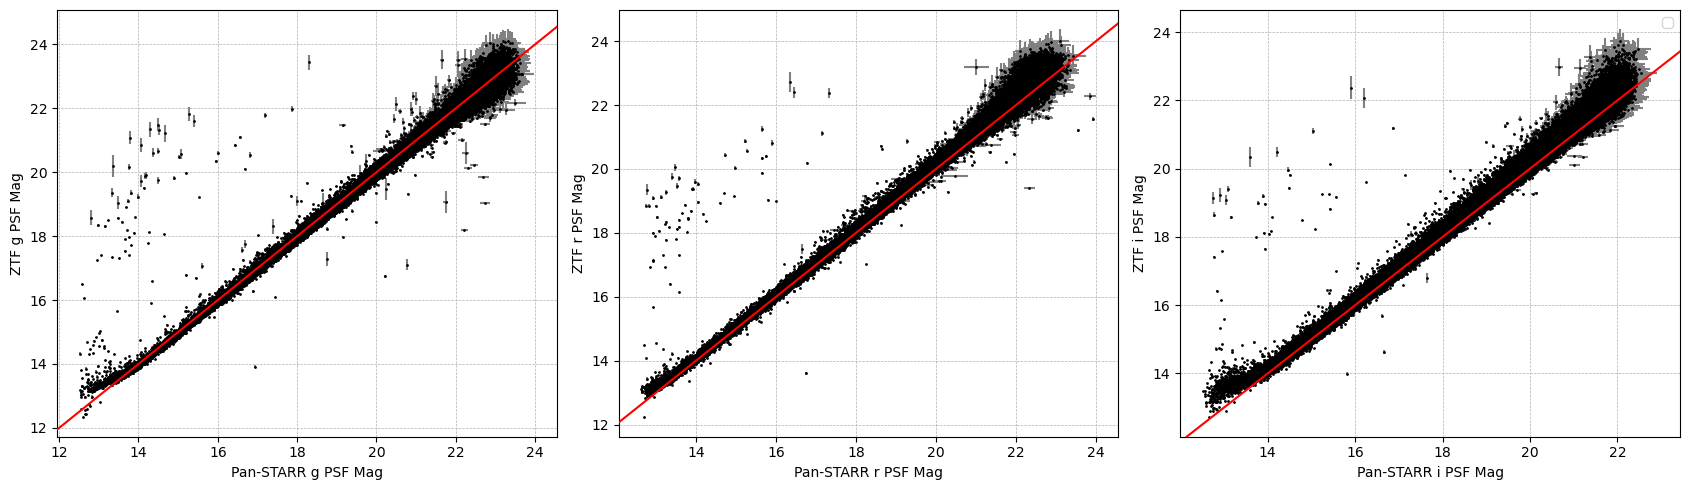

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]
    print(f'Table size: {len(tab)}')

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    ##### BOTH #####
    # Masks
    both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}PSFMag'] != -999) & (tab[f'ZTF_{band}PSFFlags'] == 0)
    ztf_upper_lim_mask = tab[f'ZTF_{band}_upper_lim']

    # Plot
    # Without upper lims
    mask = both_mask & (pstarr_snr > 3) & (ztf_snr > 3) & ~ztf_upper_lim_mask
    ax.errorbar(
        tab[mask][f'ZTF_{band}PSFMag'],
        tab[mask][f'PSTARR_{band}PSFMag'],
        xerr=tab[mask][f'ZTF_{band}PSFMagErr'],
        yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
        color='k',
        linestyle="None",
        fmt="o",
        markersize=1,
        ecolor='gray',
    )
    # # Just upper lims
    # mask = both_mask & (pstarr_snr > 3) & ztf_upper_lim_mask
    # print(f'Plotting {np.sum(mask)} / {np.sum(ztf_upper_lim_mask)} upper limits')
    # ax.errorbar(
    #     tab[mask][f'ZTF_{band}PSFMag'],
    #     tab[mask][f'PSTARR_{band}PSFMag'],
    #     xerr=[0.25 for _ in range(np.sum(mask))],
    #     yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
    #     xuplims=True,
    #     color='k',
    #     linestyle="None",
    #     fmt="o",
    #     markersize=1,
    #     ecolor='gray',
    # )

    # ##### Only in PSTARR #####
    # # Mask
    # pstarr_mask = (tab['Catalog'] == 'PSTARR') & (tab[f'PSTARR_{band}PSFMag'] != -999) & (tab[f'PSTARR_{band}PSFMagErr'] != -999)
    # mask = pstarr_mask & (pstarr_snr > 3)

    # # Plot
    # upper_lims = [UPPER_LIMIT_MAGS['ztf'][band] for _ in range(np.sum(mask))]
    # ax.errorbar(
    #     upper_lims,
    #     tab[mask][f'PSTARR_{band}PSFMag'],
    #     xerr=[0.25 for _ in range(len(upper_lims))],
    #     yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
    #     xuplims=True,
    #     color='blue',
    #     linestyle="None",
    #     fmt="o",
    #     markersize=1,
    # )

    # ##### Only in ZTF #####
    # # Mask
    # ztf_mask = (tab['Catalog'] == 'ZTF')
    # mask = ztf_mask & (ztf_snr > 3)

    # # Plot
    # upper_lims = [UPPER_LIMIT_MAGS['pstarr'][band] for _ in range(np.sum(mask))]
    # ax.errorbar(
    #     tab[mask][f'ZTF_{band}PSFMag'],
    #     upper_lims,
    #     yerr=[0.25 for _ in range(len(upper_lims))],
    #     xerr=tab[mask][f'ZTF_{band}PSFMagErr'],
    #     uplims=True,
    #     color='forestgreen',
    #     linestyle="None",
    #     fmt="o",
    #     markersize=1,
    # )

    # Formatting
    ax.axline((15, 15), slope=1, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(f'ZTF {band} PSF Mag')
    ax.set_xlabel(f'Pan-STARR {band} PSF Mag')

axes[-1].legend(markerscale=5)
plt.tight_layout()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


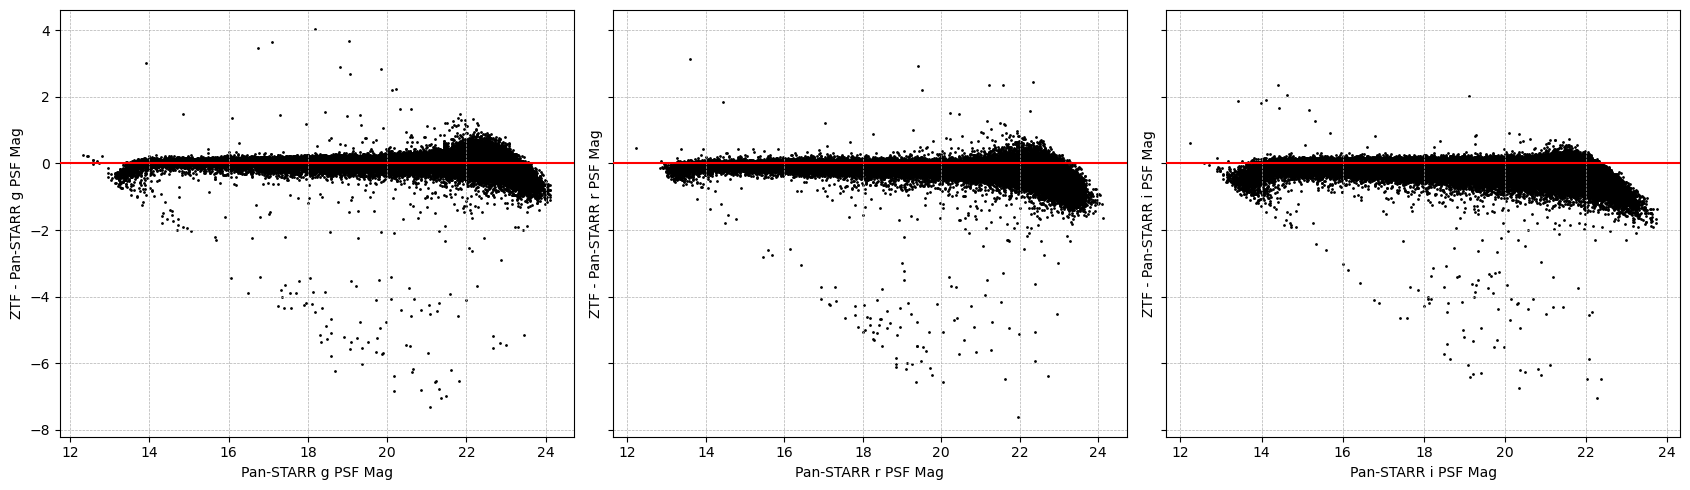

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    ##### BOTH #####
    # Masks
    snr_mask = (pstarr_snr > 3) & (ztf_snr > 3)
    both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}PSFMag'] != -999) & (tab[f'ZTF_{band}PSFFlags'] == 0)

    # Plot
    mask = both_mask & snr_mask
    ax.scatter(
        tab[mask][f'PSTARR_{band}PSFMag'],
        tab[mask][f'ZTF_{band}PSFMag'] - tab[mask][f'PSTARR_{band}PSFMag'],
        color='k',
        s=1,
    )

    # Formatting
    ax.axhline(0, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(f'ZTF - Pan-STARR {band} PSF Mag')
    ax.set_xlabel(f'Pan-STARR {band} PSF Mag')

ylims = np.array([ax.get_ylim() for ax in axes])
for ax in axes:
    ax.set_ylim(np.min(ylims), np.max(ylims))

plt.tight_layout()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34587/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


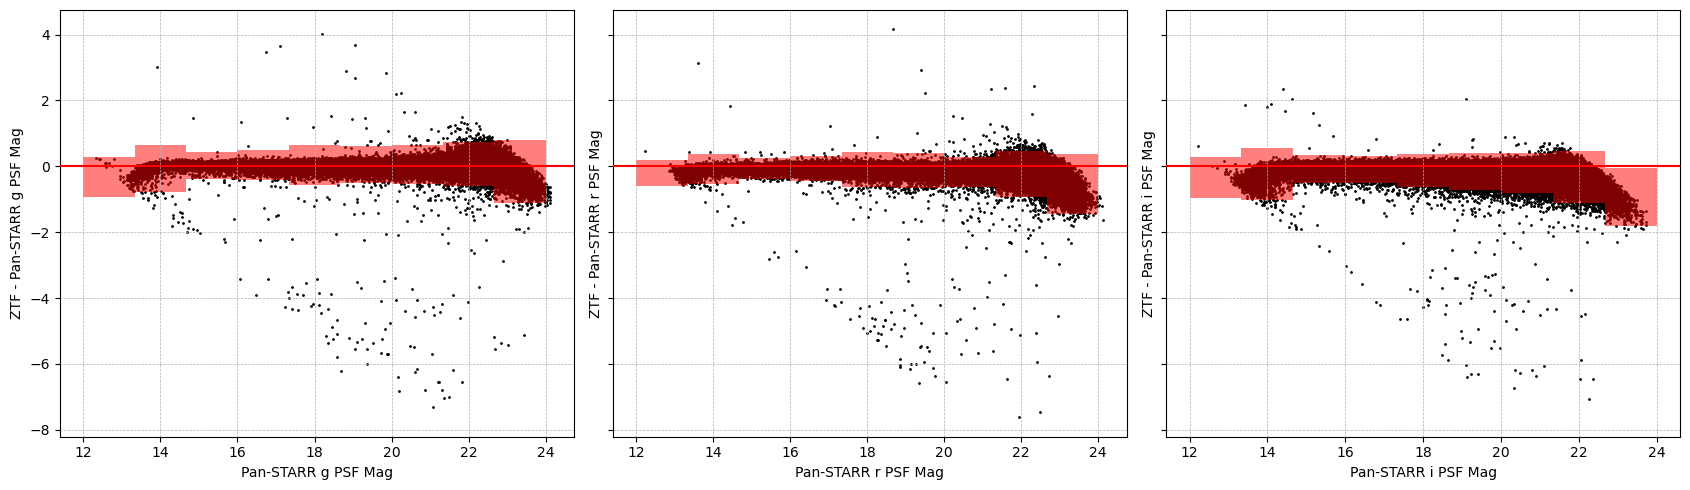

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    ##### BOTH #####
    # Masks
    snr_mask = (pstarr_snr > 3) & (ztf_snr > 3)
    both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}PSFMag'] != -999)
    mask = both_mask & snr_mask

    # Get the 3-sigma boundaries on delta mag
    mag_bin_edges = np.linspace(12, 24, num=10)
    bin_means, bin_stds = [], []
    for i in range(len(mag_bin_edges) - 1):
        lower, upper = mag_bin_edges[i], mag_bin_edges[i+1]
        bin_mask = both_mask & snr_mask & (tab[f'PSTARR_{band}PSFMag'] > lower) & (tab[f'PSTARR_{band}PSFMag'] < upper)

        bin_means.append(np.mean(tab[bin_mask][f"ZTF_{band}PSFMag"] - tab[bin_mask][f"PSTARR_{band}PSFMag"]))
        bin_stds.append(np.std(tab[bin_mask][f"ZTF_{band}PSFMag"] - tab[bin_mask][f"PSTARR_{band}PSFMag"]))

    # Plot
    ax.scatter(
        tab[mask][f'PSTARR_{band}PSFMag'],
        tab[mask][f'ZTF_{band}PSFMag'] - tab[mask][f'PSTARR_{band}PSFMag'],
        color='k',
        s=1,
    )

    # Plot the bin mean +- 3sigma with rectangles for each bin
    for lower, upper, mean, std in zip(mag_bin_edges[:-1], mag_bin_edges[1:], bin_means, bin_stds):
        rect = plt.Rectangle(
            (lower, mean - (3 * std)),
            upper - lower,
            6 * std,
            color='red',
            alpha=0.5,
            lw=0,
        )
        ax.add_patch(rect)

    # Formatting
    ax.axhline(0, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(f'ZTF - Pan-STARR {band} PSF Mag')
    ax.set_xlabel(f'Pan-STARR {band} PSF Mag')

ylims = np.array([ax.get_ylim() for ax in axes])
for ax in axes:
    ax.set_ylim(np.min(ylims), np.max(ylims))

plt.tight_layout()
plt.show()